# **Libraries**

In [1]:
!pip install torch_geometric
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.5.0+cpu.html
import torch
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from torch_geometric.transforms import NormalizeFeatures
from torch.nn import Linear
from torch_geometric.nn import GCNConv, GINConv, global_mean_pool, global_max_pool
from torch_geometric.data import Data
import torch.nn.functional as F
from torch.nn import BatchNorm1d, CrossEntropyLoss
from torch.optim import Adam
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, roc_curve
from sklearn.preprocessing import label_binarize
from datetime import datetime
import pytz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.2 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.5.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 544.0/544.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 785.3/785.3 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 6.1 MB/s eta 0:00:00


# **Dataset Visualization**

In [2]:
dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')

print("Number of Data Samples - ", len(dataset))
print("Number of Classes - ", dataset.num_classes)
print("Number of Features - ", dataset.num_node_features)

Processing...


Number of Data Samples -  600
Number of Classes -  6
Number of Features -  3


Done!


Data(edge_index=[2, 168], x=[37, 3], y=[1])
Number of Nodes -  37
Number of Edges -  84
Is Graph Undirected -  True


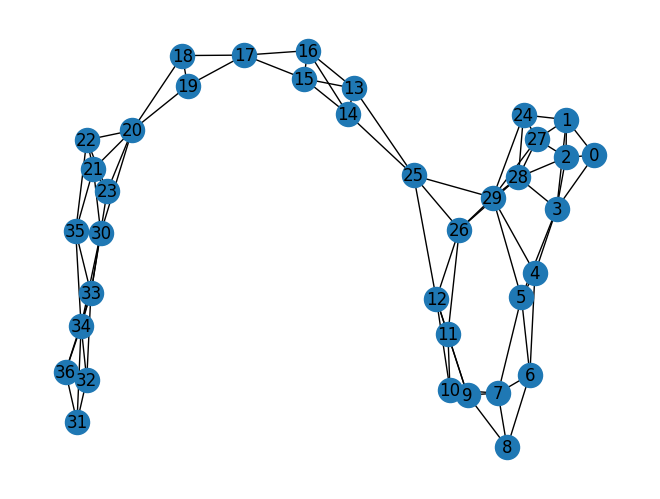

In [3]:
# Getting a sample graph
data = dataset[0]

print(data)
print("Number of Nodes - ", data.num_nodes)
print("Number of Edges - ", data.num_edges//2)
print("Is Graph Undirected - ", data.is_undirected())

# Creating a NetworkX graph
G = nx.Graph()
G.add_edges_from(data.edge_index.t().tolist())

# Visualizing the graph
nx.draw(G, with_labels=True)
plt.show()

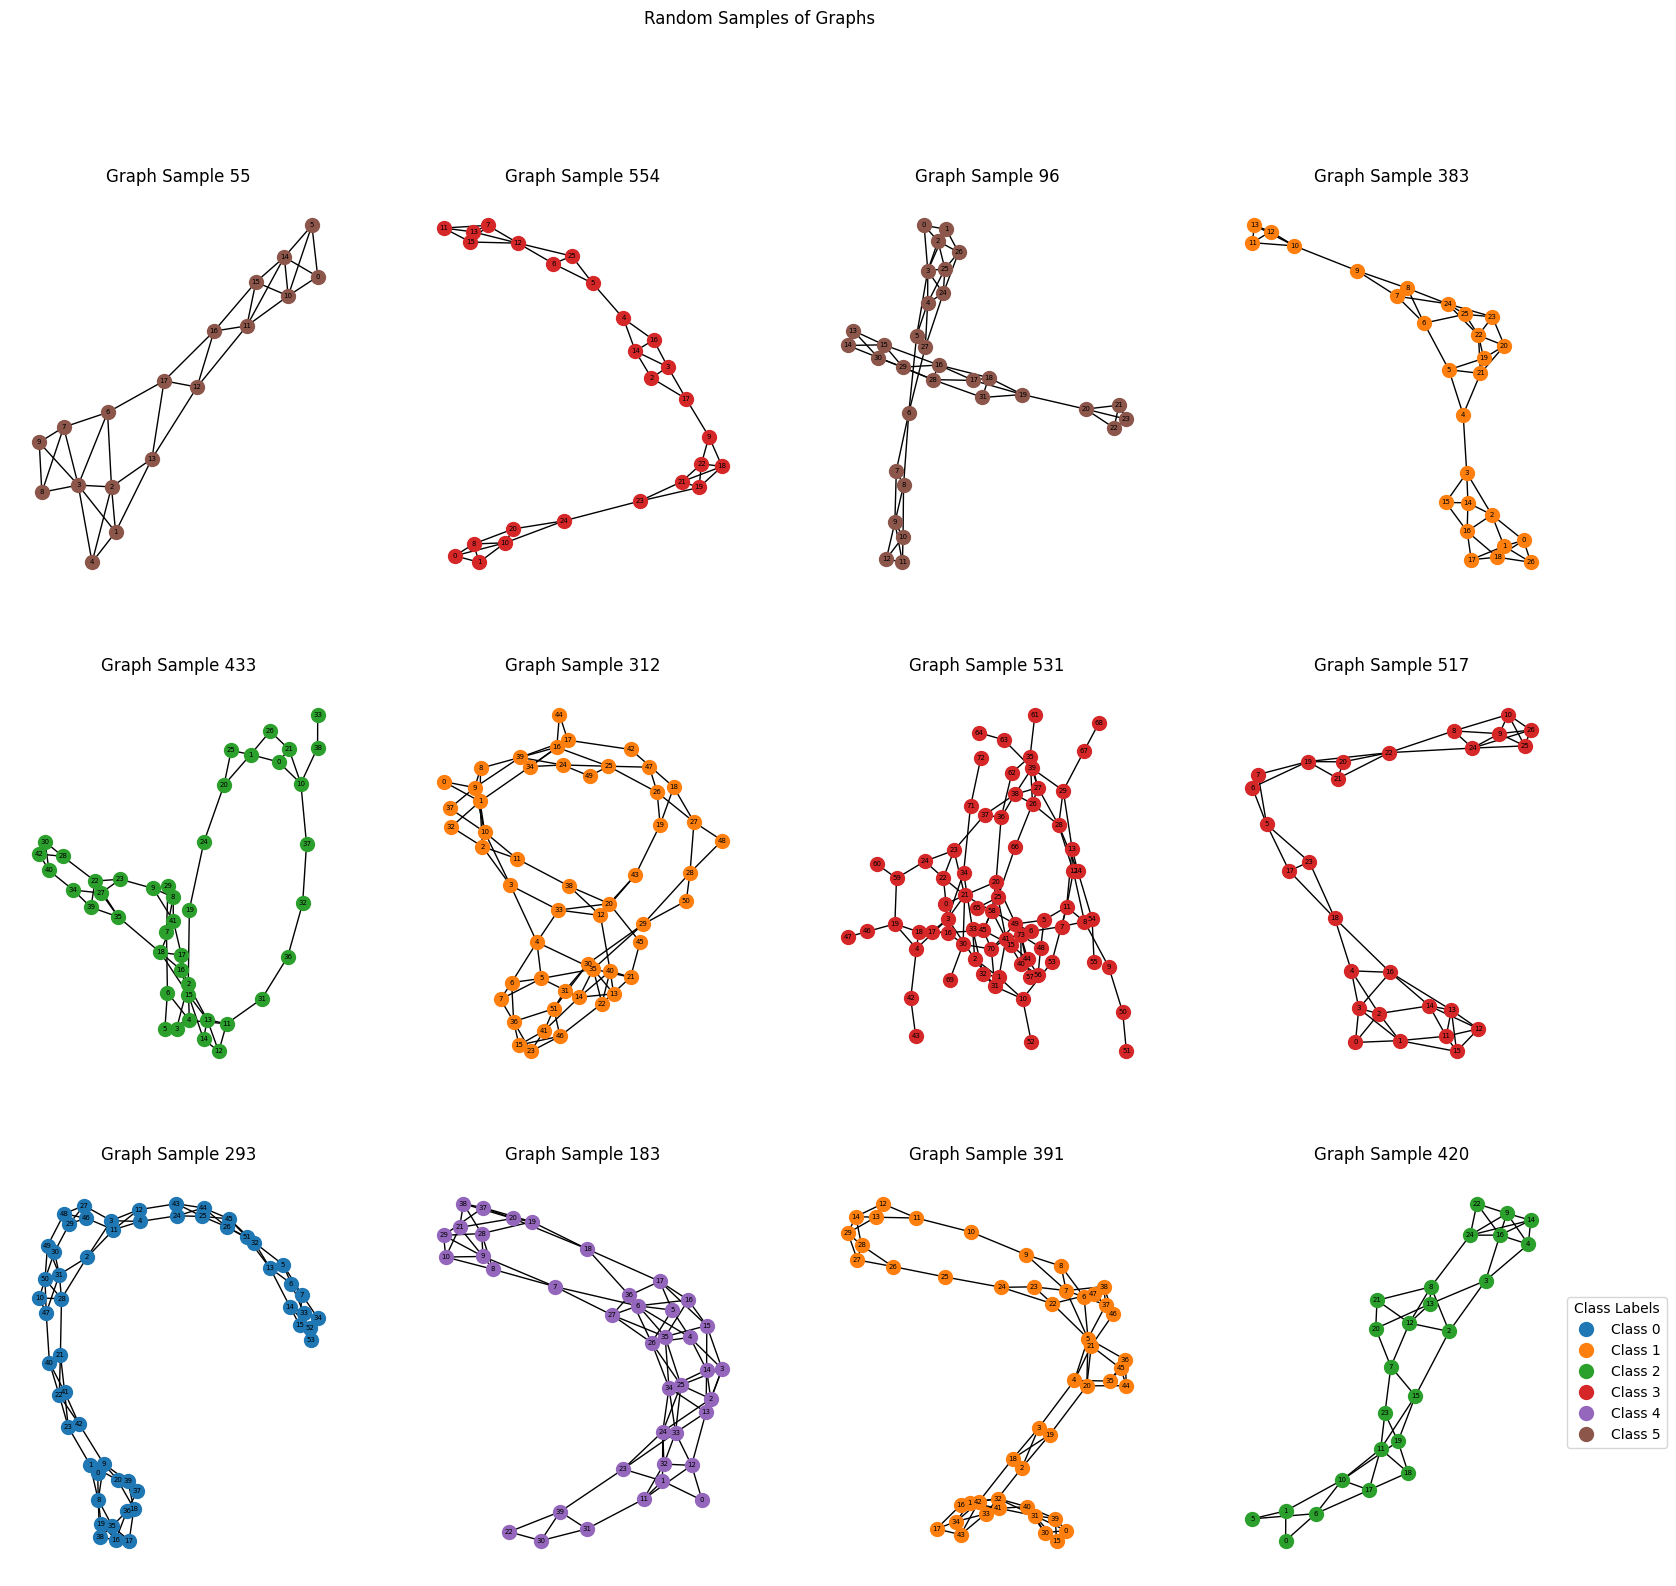

In [6]:
def draw_random_graph_samples1(dataset, dataset_name, num_classes, num_samples):
    num_rows = 3
    num_cols = 4
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 6*num_rows))
    fig.suptitle('Random Samples of Graphs')

    # Defining a colormap based on the number of unique classes
    cmap = plt.colormaps.get_cmap('tab10')

    # Getting random indices for sampling
    random_indices = random.sample(range(len(dataset)), num_samples)

    for i, index in enumerate(random_indices):
        row = i // num_cols
        col = i % num_cols

        data = dataset[index]
        edge_index, y = data.edge_index, data.y
        G = nx.Graph()
        for src, dst in edge_index.t().tolist():
            G.add_edge(src, dst)

        # Mapping class labels to colors (assuming single RGB value for all nodes)
        nodes_color = cmap(y[0])  # Assuming single class for each graph

        pos = nx.spring_layout(G)  # Positions for all nodes

        # Reshaping nodes_color to a 2D array with a single row
        nodes_color = np.array(nodes_color).reshape(1, -1)

        nx.draw(G, pos, with_labels=True, node_color=nodes_color, node_size=100, edge_color='k', linewidths=1, font_size=5, ax=axs[row, col])
        axs[row, col].set_title(f'Graph Sample {index}')

    # Custom legend for class labels
    handles = [plt.Line2D([], [], color=cmap(i), marker='o', linestyle='', markersize=10, label=f'Class {i}') for i in range(num_classes)]
    plt.legend(handles=handles, title='Class Labels', loc='center left', bbox_to_anchor=(1, 0.5))

draw_random_graph_samples1(dataset, "ENZYMES", 6, num_samples=12)

In [23]:
missingEdge = torch.isnan(data.edge_index)
print(missingEdge)

tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, F

In [24]:
missing_features_found = False

# Iterating over each graph in the dataset
for i, data in enumerate(dataset):
    # Checking for NaN values in node features
    missing_node_features = torch.isnan(data.x).any()

    if missing_node_features:
        print(f"Missing node features detected in graph {i+1}")
        missing_features_found = True
        break

if not missing_features_found:
    print("No missing node features found in the entire dataset.")

No missing node features found in the entire dataset.


# **Data Preprocessing**

In [7]:
# Applying normalization to the dataset
dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES', transform=NormalizeFeatures())

In [8]:
# Splitting the dataset into 80% train, 10% validation and 10% test set
labels = dataset.data.y.numpy()
train_indices, temp_indices = train_test_split(
    range(len(dataset)), stratify=labels, test_size=0.2, random_state=42
)
val_indices, test_indices = train_test_split(
    temp_indices, stratify=[labels[i] for i in temp_indices], test_size=0.5, random_state=42
)

train_loader = DataLoader([dataset[i] for i in train_indices], batch_size=32, shuffle=True)
val_loader = DataLoader([dataset[i] for i in val_indices], batch_size=32, shuffle=False)
test_loader = DataLoader([dataset[i] for i in test_indices], batch_size=32, shuffle=False)


/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


# **Functions for training and testing the models**

In [18]:
# Function to print Timestamp
def timestamp():
    local_tz = pytz.timezone('America/New_York')
    utc_now = datetime.now(pytz.utc)
    local_time = utc_now.astimezone(local_tz)
    print("Local Date and Time:", local_time.strftime("%Y-%m-%d %H:%M:%S"))

# Train function
def train(model):
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Validation/Test function
def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    for data in loader:
        out = model(data)
        pred = out.softmax(dim=1).detach()
        all_preds.append(pred)
        all_labels.append(data.y)
    return torch.cat(all_preds, dim=0), torch.cat(all_labels, dim=0)

# Function to compute AUC
def compute_auc(y_true, y_score, num_classes):
    unique_classes = torch.unique(y_true)
    if len(unique_classes) == 1:  # Only one class in the batch
        return None
    y_true_one_hot = F.one_hot(y_true, num_classes=num_classes).numpy()
    auc = roc_auc_score(y_true_one_hot, y_score.numpy(), multi_class='ovr')
    return auc


# Function to plot ROC curve for the test dataset
def plot_roc_curve(y_true, y_score, num_classes):

    # Binarize the true labels
    y_true_bin = label_binarize(y_true.numpy(), classes=list(range(num_classes)))

    # Calculate ROC curve for each class
    fpr = dict()
    tpr = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i].numpy())

    # Plot all ROC curves
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} ROC curve')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Test Set')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Test function to evaluate the trained model on test data
def test_model(model, test_loader):

    test_preds, test_labels = evaluate(model, test_loader)
    test_accuracy = accuracy_score(test_labels.numpy(), torch.argmax(test_preds, dim=1).numpy())
    test_f1 = f1_score(test_labels.numpy(), torch.argmax(test_preds, dim=1).numpy(), average='macro')
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")

    plot_roc_curve(test_labels, test_preds, num_classes=dataset.num_classes)
    timestamp()

# **GCN 1 Layer Model**

In [25]:
class GCN_1_Layer(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN_1_Layer, self).__init__()
        # Define 1 GCN layer
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim)

        # Final fully connected layer for classification
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # First GCN layer
        x = self.conv1(x, edge_index)
        x = self.bn1(x)  # Batch Normalization
        x = F.relu(x)    # ReLU activation

        # Global max pooling
        x = global_max_pool(x, data.batch)

        # Final classification layer
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

Epoch: 010, Train Loss: 1.7672, Val Accuracy: 0.2667, Val AUC: 0.5830
Epoch: 020, Train Loss: 1.6744, Val Accuracy: 0.3167, Val AUC: 0.6040
Epoch: 030, Train Loss: 1.6790, Val Accuracy: 0.2500, Val AUC: 0.6100
Epoch: 040, Train Loss: 1.6046, Val Accuracy: 0.3000, Val AUC: 0.6127
Epoch: 050, Train Loss: 1.6212, Val Accuracy: 0.2167, Val AUC: 0.6173
Epoch: 060, Train Loss: 1.5889, Val Accuracy: 0.1833, Val AUC: 0.6177
Epoch: 070, Train Loss: 1.5951, Val Accuracy: 0.3000, Val AUC: 0.6190
Epoch: 080, Train Loss: 1.5685, Val Accuracy: 0.3000, Val AUC: 0.6480
Epoch: 090, Train Loss: 1.5544, Val Accuracy: 0.2833, Val AUC: 0.6377
Epoch: 100, Train Loss: 1.5269, Val Accuracy: 0.2833, Val AUC: 0.6213
Epoch: 110, Train Loss: 1.5257, Val Accuracy: 0.3167, Val AUC: 0.6280
Epoch: 120, Train Loss: 1.5320, Val Accuracy: 0.2333, Val AUC: 0.5907
Epoch: 130, Train Loss: 1.4987, Val Accuracy: 0.3167, Val AUC: 0.6157
Epoch: 140, Train Loss: 1.5116, Val Accuracy: 0.2500, Val AUC: 0.6077
Epoch: 150, Train Lo

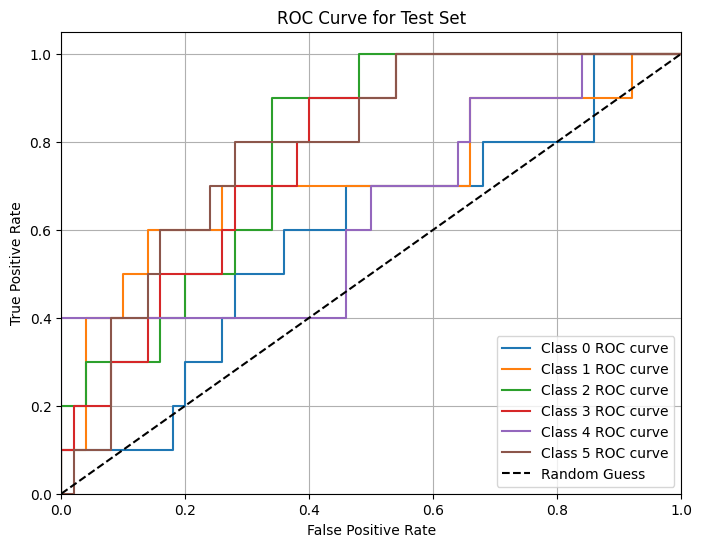

Local Date and Time: 2024-11-22 00:24:47


In [26]:
# Initialize model
model_GCN_1_Layer_H1 = GCN_1_Layer(input_dim=dataset.num_node_features, hidden_dim=128, output_dim=dataset.num_classes)

# Optimizer
optimizer = torch.optim.Adam(model_GCN_1_Layer_H1.parameters(), lr=0.01)

# Loss function
criterion = torch.nn.CrossEntropyLoss()

# Training and Evaluation Loop
num_epochs = 200
for epoch in range(1, num_epochs + 1):
    # Training Step
    train_loss = train(model_GCN_1_Layer_H1)

    # Evaluate on Validation and Test sets
    val_preds, val_labels = evaluate(model_GCN_1_Layer_H1, val_loader)
    val_accuracy = accuracy_score(val_labels.numpy(), torch.argmax(val_preds, dim=1).numpy())
    val_auc = compute_auc(val_labels, val_preds, num_classes=dataset.num_classes)

    # Print results every 10 epochs
    if epoch % 10 == 0:
        val_accuracy_text = f'{val_accuracy:.4f}'
        val_auc_text = f'{val_auc:.4f}'
        #test_auc_text = f'{test_auc:.4f}'
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Accuracy: {val_accuracy_text}, Val AUC: {val_auc_text}')

# Saving the trained model
torch.save(model_GCN_1_Layer_H1.state_dict(), 'model_GCN_1_Layer_H1.pth')

# Loading the model for testing
# Load the saved model
model_GCN_1_Layer_H1.load_state_dict(torch.load('model_GCN_1_Layer_H1.pth', weights_only=True))
test_model(model_GCN_1_Layer_H1, test_loader)

Epoch: 010, Train Loss: 1.6848, Val Accuracy: 0.2333, Val AUC: 0.5827
Epoch: 020, Train Loss: 1.6638, Val Accuracy: 0.2500, Val AUC: 0.5807
Epoch: 030, Train Loss: 1.6229, Val Accuracy: 0.2667, Val AUC: 0.5870
Epoch: 040, Train Loss: 1.6162, Val Accuracy: 0.2500, Val AUC: 0.5770
Epoch: 050, Train Loss: 1.6177, Val Accuracy: 0.2333, Val AUC: 0.5800
Epoch: 060, Train Loss: 1.6030, Val Accuracy: 0.2333, Val AUC: 0.5740
Epoch: 070, Train Loss: 1.5722, Val Accuracy: 0.2333, Val AUC: 0.5793
Epoch: 080, Train Loss: 1.5830, Val Accuracy: 0.2333, Val AUC: 0.5740
Epoch: 090, Train Loss: 1.5600, Val Accuracy: 0.2167, Val AUC: 0.5673
Epoch: 100, Train Loss: 1.5624, Val Accuracy: 0.2167, Val AUC: 0.5800
Epoch: 110, Train Loss: 1.5455, Val Accuracy: 0.2333, Val AUC: 0.5727
Epoch: 120, Train Loss: 1.5523, Val Accuracy: 0.2333, Val AUC: 0.5763
Epoch: 130, Train Loss: 1.5551, Val Accuracy: 0.2000, Val AUC: 0.5763
Epoch: 140, Train Loss: 1.5329, Val Accuracy: 0.2167, Val AUC: 0.5690
Epoch: 150, Train Lo

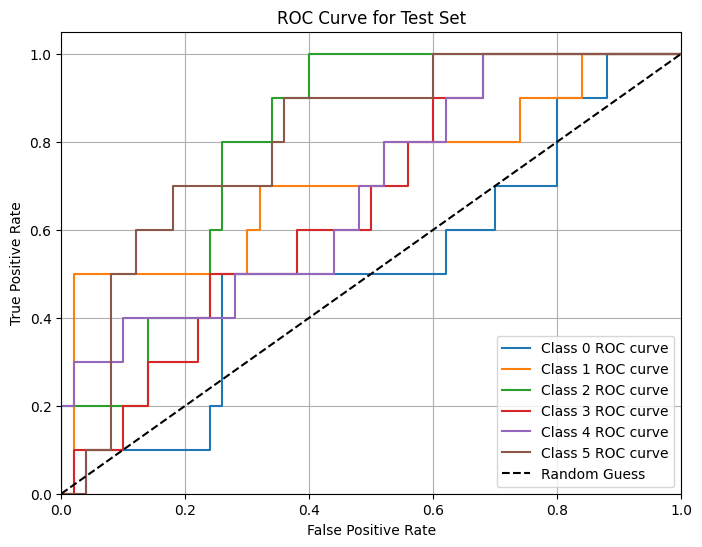

Local Date and Time: 2024-11-22 00:29:05


In [28]:
# Initialize model
model_GCN_1_Layer_H2 = GCN_1_Layer(input_dim=dataset.num_node_features, hidden_dim=128, output_dim=dataset.num_classes)

# Optimizer
optimizer = torch.optim.Adam(model_GCN_1_Layer_H2.parameters(), lr=0.001, weight_decay=5e-4)

# Loss function
criterion = torch.nn.CrossEntropyLoss()

# Training and Evaluation Loop
num_epochs = 300
for epoch in range(1, num_epochs + 1):
    # Training Step
    train_loss = train(model_GCN_1_Layer_H2)

    # Evaluate on Validation and Test sets
    val_preds, val_labels = evaluate(model_GCN_1_Layer_H2, val_loader)
    val_accuracy = accuracy_score(val_labels.numpy(), torch.argmax(val_preds, dim=1).numpy())
    val_auc = compute_auc(val_labels, val_preds, num_classes=dataset.num_classes)

    # Print results every 10 epochs
    if epoch % 10 == 0:
        val_accuracy_text = f'{val_accuracy:.4f}'
        val_auc_text = f'{val_auc:.4f}'
        #test_auc_text = f'{test_auc:.4f}'
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Accuracy: {val_accuracy_text}, Val AUC: {val_auc_text}')

# Saving the trained model
torch.save(model_GCN_1_Layer_H2.state_dict(), 'model_GCN_1_Layer_H2.pth')

# Loading the model for testing
# Load the saved model
model_GCN_1_Layer_H2.load_state_dict(torch.load('model_GCN_1_Layer_H2.pth', weights_only=True))
test_model(model_GCN_1_Layer_H2, test_loader)

# **GCN 2 Layer Model**

In [29]:
class GCN_2_Layer(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN_2_Layer, self).__init__()
        # Define 2 GCN layers
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = torch.nn.BatchNorm1d(hidden_dim)

        # Final fully connected layer for classification
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # First GCN layer
        x = self.conv1(x, edge_index)
        x = self.bn1(x)  # Batch Normalization
        x = F.relu(x)    # ReLU activation

        # Second GCN layer
        x = self.conv2(x, edge_index)
        x = self.bn2(x)  # Batch Normalization
        x = F.relu(x)    # ReLU activation

        # Global max pooling
        x = global_max_pool(x, data.batch)

        # Final classification layer
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

Epoch: 010, Train Loss: 1.6236, Val Accuracy: 0.3333, Val AUC: 0.7050
Epoch: 020, Train Loss: 1.5410, Val Accuracy: 0.3167, Val AUC: 0.6667
Epoch: 030, Train Loss: 1.4557, Val Accuracy: 0.3333, Val AUC: 0.6890
Epoch: 040, Train Loss: 1.4455, Val Accuracy: 0.3500, Val AUC: 0.7070
Epoch: 050, Train Loss: 1.3776, Val Accuracy: 0.3000, Val AUC: 0.7057
Epoch: 060, Train Loss: 1.3341, Val Accuracy: 0.3833, Val AUC: 0.7063
Epoch: 070, Train Loss: 1.3207, Val Accuracy: 0.3667, Val AUC: 0.7290
Epoch: 080, Train Loss: 1.2681, Val Accuracy: 0.3167, Val AUC: 0.6967
Epoch: 090, Train Loss: 1.2311, Val Accuracy: 0.3667, Val AUC: 0.7187
Epoch: 100, Train Loss: 1.2683, Val Accuracy: 0.3500, Val AUC: 0.7077
Epoch: 110, Train Loss: 1.1759, Val Accuracy: 0.3667, Val AUC: 0.7190
Epoch: 120, Train Loss: 1.1657, Val Accuracy: 0.3500, Val AUC: 0.6987
Epoch: 130, Train Loss: 1.1002, Val Accuracy: 0.3500, Val AUC: 0.7517
Epoch: 140, Train Loss: 1.1144, Val Accuracy: 0.4000, Val AUC: 0.7187
Epoch: 150, Train Lo

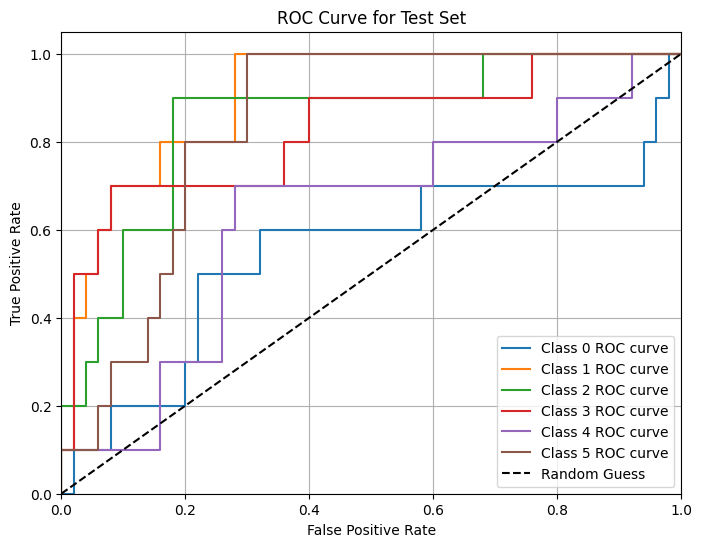

Local Date and Time: 2024-11-22 00:40:23


In [32]:
# Initialize model
model_GCN_2_Layer_H1 = GCN_2_Layer(input_dim=dataset.num_node_features, hidden_dim=128, output_dim=dataset.num_classes)

# Optimizer
optimizer = torch.optim.Adam(model_GCN_2_Layer_H1.parameters(), lr=0.001, weight_decay=5e-4)

# Loss function
criterion = torch.nn.CrossEntropyLoss()

# Training and Evaluation Loop
num_epochs = 300
for epoch in range(1, num_epochs + 1):
    # Training Step
    train_loss = train(model_GCN_2_Layer_H1)

    # Evaluate on Validation and Test sets
    val_preds, val_labels = evaluate(model_GCN_2_Layer_H1, val_loader)
    val_accuracy = accuracy_score(val_labels.numpy(), torch.argmax(val_preds, dim=1).numpy())
    val_auc = compute_auc(val_labels, val_preds, num_classes=dataset.num_classes)

    # Print results every 10 epochs
    if epoch % 10 == 0:
        val_accuracy_text = f'{val_accuracy:.4f}'
        val_auc_text = f'{val_auc:.4f}'
        #test_auc_text = f'{test_auc:.4f}'
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Accuracy: {val_accuracy_text}, Val AUC: {val_auc_text}')

# Saving the trained model
torch.save(model_GCN_2_Layer_H1.state_dict(), 'model_GCN_2_Layer_H1.pth')

# Loading the model for testing
# Load the saved model
model_GCN_2_Layer_H1.load_state_dict(torch.load('model_GCN_2_Layer_H1.pth', weights_only=True))
test_model(model_GCN_2_Layer_H1, test_loader)

Epoch: 010, Train Loss: 1.6830, Val Accuracy: 0.3500, Val AUC: 0.6913
Epoch: 020, Train Loss: 1.6386, Val Accuracy: 0.3667, Val AUC: 0.6963
Epoch: 030, Train Loss: 1.6055, Val Accuracy: 0.4000, Val AUC: 0.6900
Epoch: 040, Train Loss: 1.5774, Val Accuracy: 0.4167, Val AUC: 0.6837
Epoch: 050, Train Loss: 1.5579, Val Accuracy: 0.3667, Val AUC: 0.6947
Epoch: 060, Train Loss: 1.5646, Val Accuracy: 0.4000, Val AUC: 0.6993
Epoch: 070, Train Loss: 1.5342, Val Accuracy: 0.4000, Val AUC: 0.6973
Epoch: 080, Train Loss: 1.5117, Val Accuracy: 0.4000, Val AUC: 0.6983
Epoch: 090, Train Loss: 1.4990, Val Accuracy: 0.4000, Val AUC: 0.7040
Epoch: 100, Train Loss: 1.4807, Val Accuracy: 0.4500, Val AUC: 0.7117
Epoch: 110, Train Loss: 1.4799, Val Accuracy: 0.4000, Val AUC: 0.7057
Epoch: 120, Train Loss: 1.4390, Val Accuracy: 0.4333, Val AUC: 0.7067
Epoch: 130, Train Loss: 1.4522, Val Accuracy: 0.4000, Val AUC: 0.7010
Epoch: 140, Train Loss: 1.4251, Val Accuracy: 0.4000, Val AUC: 0.7097
Epoch: 150, Train Lo

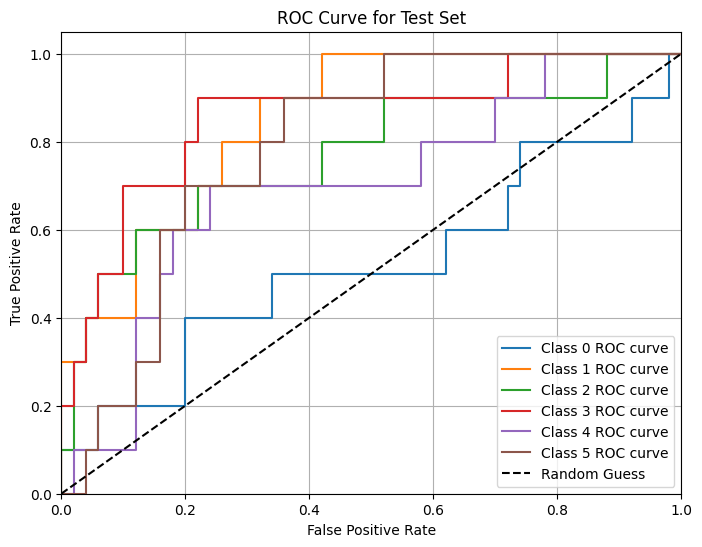

Local Date and Time: 2024-11-22 01:27:12


In [35]:
# Initialize model
model_GCN_2_Layer_H2 = GCN_2_Layer(input_dim=dataset.num_node_features, hidden_dim=128, output_dim=dataset.num_classes)

# Optimizer
optimizer = torch.optim.Adam(model_GCN_2_Layer_H2.parameters(), lr=0.0001, weight_decay=5e-4)

# Loss function
criterion = torch.nn.CrossEntropyLoss()

# Training and Evaluation Loop
num_epochs = 300
for epoch in range(1, num_epochs + 1):
    # Training Step
    train_loss = train(model_GCN_2_Layer_H2)

    # Evaluate on Validation and Test sets
    val_preds, val_labels = evaluate(model_GCN_2_Layer_H2, val_loader)
    val_accuracy = accuracy_score(val_labels.numpy(), torch.argmax(val_preds, dim=1).numpy())
    val_auc = compute_auc(val_labels, val_preds, num_classes=dataset.num_classes)

    # Print results every 10 epochs
    if epoch % 10 == 0:
        val_accuracy_text = f'{val_accuracy:.4f}'
        val_auc_text = f'{val_auc:.4f}'
        #test_auc_text = f'{test_auc:.4f}'
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Accuracy: {val_accuracy_text}, Val AUC: {val_auc_text}')

# Saving the trained model
torch.save(model_GCN_2_Layer_H2.state_dict(), 'model_GCN_2_Layer_H2.pth')

# Loading the model for testing
# Load the saved model
model_GCN_2_Layer_H2.load_state_dict(torch.load('model_GCN_2_Layer_H2.pth', weights_only=True))
test_model(model_GCN_2_Layer_H2, test_loader)

# **GCN 3 Layer Model**

In [21]:
class GCN_3_Layer(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN_3_Layer, self).__init__()
        # Define 3 GCN layers
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = torch.nn.BatchNorm1d(hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.bn3 = torch.nn.BatchNorm1d(hidden_dim)

        # Final fully connected layer for classification
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # First GCN layer
        x = self.conv1(x, edge_index)
        x = self.bn1(x)  # Batch Normalization
        x = F.relu(x)    # ReLU activation

        # Second GCN layer
        x = self.conv2(x, edge_index)
        x = self.bn2(x)  # Batch Normalization
        x = F.relu(x)    # ReLU activation

        # Third GCN layer
        x = self.conv3(x, edge_index)
        x = self.bn3(x)  # Batch Normalization
        x = F.relu(x)    # ReLU activation

        # Global max pooling
        x = global_max_pool(x, data.batch)

        # Final classification layer
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

Epoch: 010, Train Loss: 1.6643, Val Accuracy: 0.3167, Val AUC: 0.6550
Epoch: 020, Train Loss: 1.4922, Val Accuracy: 0.2667, Val AUC: 0.5853
Epoch: 030, Train Loss: 1.5033, Val Accuracy: 0.3167, Val AUC: 0.6967
Epoch: 040, Train Loss: 1.3080, Val Accuracy: 0.2333, Val AUC: 0.6353
Epoch: 050, Train Loss: 1.1499, Val Accuracy: 0.2500, Val AUC: 0.6583
Epoch: 060, Train Loss: 1.1491, Val Accuracy: 0.2000, Val AUC: 0.6230
Epoch: 070, Train Loss: 0.9864, Val Accuracy: 0.3667, Val AUC: 0.7310
Epoch: 080, Train Loss: 0.9739, Val Accuracy: 0.3333, Val AUC: 0.6527
Epoch: 090, Train Loss: 0.7395, Val Accuracy: 0.2667, Val AUC: 0.6883
Epoch: 100, Train Loss: 0.6039, Val Accuracy: 0.3000, Val AUC: 0.6863
Epoch: 110, Train Loss: 0.5252, Val Accuracy: 0.3833, Val AUC: 0.7693
Epoch: 120, Train Loss: 0.4247, Val Accuracy: 0.4333, Val AUC: 0.7917
Epoch: 130, Train Loss: 0.4204, Val Accuracy: 0.4833, Val AUC: 0.7963
Epoch: 140, Train Loss: 0.3183, Val Accuracy: 0.4500, Val AUC: 0.7820
Epoch: 150, Train Lo

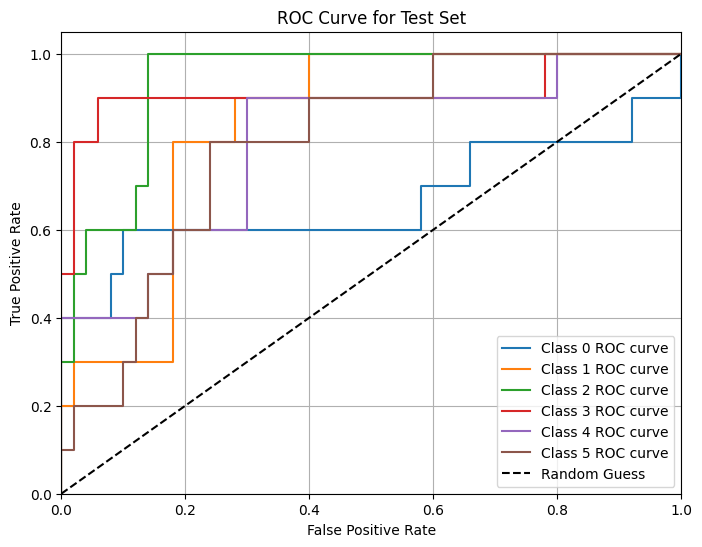

Local Date and Time: 2024-11-22 00:14:18


In [22]:
# Initialize model
model_GCN_3_Layer = GCN_3_Layer(input_dim=dataset.num_node_features, hidden_dim=128, output_dim=dataset.num_classes)

# Optimizer
optimizer = torch.optim.Adam(model_GCN_3_Layer.parameters(), lr=0.01)

# Loss function
criterion = torch.nn.CrossEntropyLoss()

# Training and Evaluation Loop
num_epochs = 300
for epoch in range(1, num_epochs + 1):
    # Training Step
    train_loss = train(model_GCN_3_Layer)

    # Evaluate on Validation and Test sets
    val_preds, val_labels = evaluate(model_GCN_3_Layer, val_loader)
    val_accuracy = accuracy_score(val_labels.numpy(), torch.argmax(val_preds, dim=1).numpy())
    val_auc = compute_auc(val_labels, val_preds, num_classes=dataset.num_classes)

    # Print results every 10 epochs
    if epoch % 10 == 0:
        val_accuracy_text = f'{val_accuracy:.4f}'
        val_auc_text = f'{val_auc:.4f}'
        #test_auc_text = f'{test_auc:.4f}'
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Accuracy: {val_accuracy_text}, Val AUC: {val_auc_text}')

# Saving the trained model
torch.save(model_GCN_3_Layer.state_dict(), 'model_GCN_3_Layer.pth')

# Loading the model for testing
# Load the saved model
model_GCN_3_Layer.load_state_dict(torch.load('model_GCN_3_Layer.pth', weights_only=True))
test_model(model_GCN_3_Layer, test_loader)

# **GCN 4 Layer Model**

In [33]:
class GCN_4_Layer(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN_4_Layer, self).__init__()
        # Define 3 GCN layers
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = torch.nn.BatchNorm1d(hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.bn3 = torch.nn.BatchNorm1d(hidden_dim)
        self.conv4 = GCNConv(hidden_dim, hidden_dim)
        self.bn4 = torch.nn.BatchNorm1d(hidden_dim)

        # Final fully connected layer for classification
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # First GCN layer
        x = self.conv1(x, edge_index)
        x = self.bn1(x)  # Batch Normalization
        x = F.relu(x)    # ReLU activation

        # Second GCN layer
        x = self.conv2(x, edge_index)
        x = self.bn2(x)  # Batch Normalization
        x = F.relu(x)    # ReLU activation

        # Third GCN layer
        x = self.conv3(x, edge_index)
        x = self.bn3(x)  # Batch Normalization
        x = F.relu(x)    # ReLU activation

        # Fourth GCN layer
        x = self.conv4(x, edge_index)
        x = self.bn4(x)  # Batch Normalization
        x = F.relu(x)    # ReLU activation
        x = F.dropout(x, p=0.5, training=self.training) # Dropout layer
        # Global max pooling
        x = global_max_pool(x, data.batch)

        # Final classification layer
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

Epoch: 010, Train Loss: 1.4261, Val Accuracy: 0.3667, Val AUC: 0.6983
Epoch: 020, Train Loss: 1.2742, Val Accuracy: 0.3500, Val AUC: 0.7197
Epoch: 030, Train Loss: 1.0754, Val Accuracy: 0.4333, Val AUC: 0.7263
Epoch: 040, Train Loss: 1.0199, Val Accuracy: 0.3667, Val AUC: 0.7247
Epoch: 050, Train Loss: 0.7886, Val Accuracy: 0.4000, Val AUC: 0.7730
Epoch: 060, Train Loss: 0.7283, Val Accuracy: 0.5333, Val AUC: 0.7723
Epoch: 070, Train Loss: 0.5309, Val Accuracy: 0.4000, Val AUC: 0.7190
Epoch: 080, Train Loss: 0.5111, Val Accuracy: 0.3833, Val AUC: 0.7397
Epoch: 090, Train Loss: 0.4276, Val Accuracy: 0.3833, Val AUC: 0.7617
Epoch: 100, Train Loss: 0.3699, Val Accuracy: 0.4333, Val AUC: 0.7763
Epoch: 110, Train Loss: 0.3015, Val Accuracy: 0.4667, Val AUC: 0.7607
Epoch: 120, Train Loss: 0.2550, Val Accuracy: 0.4667, Val AUC: 0.7517
Epoch: 130, Train Loss: 0.1861, Val Accuracy: 0.5167, Val AUC: 0.7687
Epoch: 140, Train Loss: 0.1830, Val Accuracy: 0.5167, Val AUC: 0.7880
Epoch: 150, Train Lo

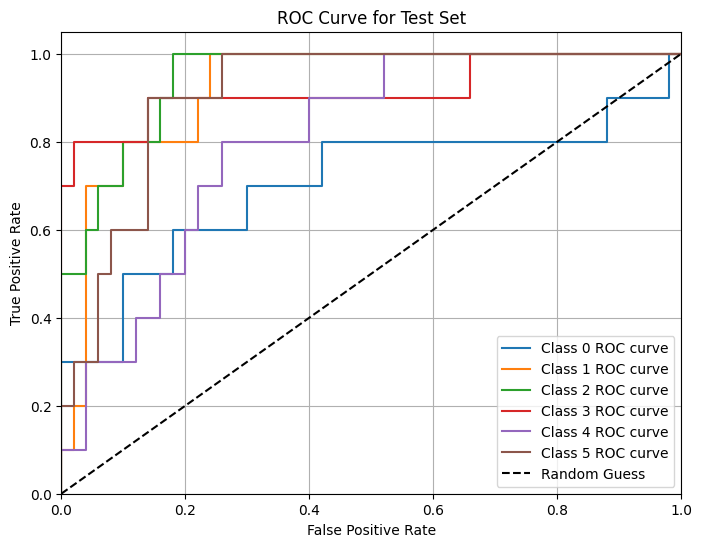

Local Date and Time: 2024-11-22 00:46:24


In [34]:
# Initialize model
model_GCN_4_Layer = GCN_4_Layer(input_dim=dataset.num_node_features, hidden_dim=128, output_dim=dataset.num_classes)

# Optimizer
optimizer = torch.optim.Adam(model_GCN_4_Layer.parameters(), lr=0.001, weight_decay=5e-4)

# Loss function
criterion = torch.nn.CrossEntropyLoss()

# Training and Evaluation Loop
num_epochs = 300
for epoch in range(1, num_epochs + 1):
    # Training Step
    train_loss = train(model_GCN_4_Layer)

    # Evaluate on Validation and Test sets
    val_preds, val_labels = evaluate(model_GCN_4_Layer, val_loader)
    val_accuracy = accuracy_score(val_labels.numpy(), torch.argmax(val_preds, dim=1).numpy())
    val_auc = compute_auc(val_labels, val_preds, num_classes=dataset.num_classes)

    # Print results every 10 epochs
    if epoch % 10 == 0:
        val_accuracy_text = f'{val_accuracy:.4f}'
        val_auc_text = f'{val_auc:.4f}'
        #test_auc_text = f'{test_auc:.4f}'
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Accuracy: {val_accuracy_text}, Val AUC: {val_auc_text}')

# Saving the trained model
torch.save(model_GCN_4_Layer.state_dict(), 'model_GCN_4_Layer.pth')

# Loading the model for testing
# Load the saved model
model_GCN_4_Layer.load_state_dict(torch.load('model_GCN_4_Layer.pth', weights_only=True))
test_model(model_GCN_4_Layer, test_loader)